# Registration of $n$-cameras from their pairwise poses

### Goal

Suppose $n$ cameras observe a number of 3D points whose geometry are not known.  Using 2D-2D correspondences, we assume the relative pose of each pair in the $n$ cameras is given as $R_{ij}, t_{ij}$ satisfying $X_j = R_{ij} X_i + t_{ij}$ where $|t_{ij}| = 1$.
* Notice that the scale of $t$ cannot be determined from 2D-2D correspondences, and hence $|t_{ij}|=1$.
* The $n$ cameras do not necessarily observe all the points.  On estimating the relative pose, the camera pair can use only the points visible (identified) from both.
* Some pairs of the cameras may not observe a sufficient number of points for their relative pose estimation (e.g. they do not share the field-of-view).  This is OK, as long as each camera is *connected* to 2 cameras. That is, given a camera graph $G$ whose edges denote camera pairs having their relative poses estimated, the minimum degree of the graph $\delta(G)$ should satisfy $\delta(G) \ge 2$.

Given $R_{ij}, t_{ij}$ pairs, this notebook estimates their poses $R_{i}, t_{i}$ in a unified coordinate system. In particular, we use the first camera coordinate system as the world coordinate system, i.e., $R_1 = I_{3{\times}3}, t_1 = (0, 0, 0)^\top$.

* Input:
  * $R_{ij}, t_{ij}$
* Output:
  * $R_{i}, t_{i}$

## Libraries

In [1]:
%matplotlib notebook
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pycalib.plot import plotCamera
from pycalib.calib import lookat, triangulate, excalib2, pose_registration, relativize


## Synthetic data

In [2]:
# 3D points
# X_gt = (np.random.rand(16, 3) - 0.5)*5 # random points centered at [0, 0, 0]
X_gt = np.array(np.meshgrid(np.linspace(-1, 1, 3), np.linspace(-1, 1, 3), np.linspace(-1, 1, 3))).reshape((3, -1)).T  # 3D grid points
Np = X_gt.shape[0]
print('X_gt:', X_gt.shape)

# Camera intrinsics
K = np.array([[600, 0, 320], [0, 600, 240], [0, 0, 1]]).astype(np.float)  # VGA camera

# Camera poses: cameras are at the vertices of a hexagon
t = 2 * np.pi / 5 * np.arange(5)
v_gt = np.vstack((10*np.cos(t), 10*np.sin(t), np.zeros(t.shape))).T
Nc = v_gt.shape[0]
R_gt = []
t_gt = []
P_gt = []
rvec_gt = []
for i in range(Nc):
    t = v_gt[i,:]
    R, t = lookat(t, np.zeros(3), np.array([0, 1, 0]))
    R_gt.append(R)
    t_gt.append(t)
    P_gt.append(K @ np.hstack((R, t)))
    rvec_gt.append(cv2.Rodrigues(R)[0])
R_gt = np.array(R_gt)
t_gt = np.array(t_gt)
P_gt = np.array(P_gt)
rvec_gt = np.array(rvec_gt)
print('R_gt:', R_gt.shape)
print('t_gt:', t_gt.shape)
print('P_gt:', P_gt.shape)
print('rvec_gt:', rvec_gt.shape)

# 2D observations points
x = []
for i in range(Nc):
    xt = cv2.projectPoints(X_gt.reshape((-1, 1, 3)), rvec_gt[i], t_gt[i], K, None)[0].reshape((-1, 2))
    x.append(xt)
x = np.array(x)
print('x:', x.shape)

# Verify triangulation
Y = []
for i in range(Np):
    y = triangulate(x[:,i,:].reshape((-1,2)), P_gt)
    #print(y)
    Y.append(y)
Y = np.array(Y).T
Y = Y[:3,:] / Y[3,:]
assert np.allclose(0, X_gt - Y.T)

# Verify z > 0 at each camera
for i in range(Nc):
    Xc = R_gt[i] @ X_gt.T + t_gt[i]
    assert np.all(Xc[2, :] > 0)


X_gt: (27, 3)
R_gt: (5, 3, 3)
t_gt: (5, 3, 1)
P_gt: (5, 3, 4)
rvec_gt: (5, 3, 1)
x: (5, 27, 2)


## Relative pose estimation

Now we have a set of corresponding points for each pair of the cameras.  Given such correspondences, the cell below does 2-view camera calibration for each pair.


In [3]:
Rt_pairs = dict()
for i in range(Nc-1):
    xi = cv2.convertPointsToHomogeneous(x[i]).reshape((-1,3)).T
    for j in range(i+1, Nc):
        xj = cv2.convertPointsToHomogeneous(x[j]).reshape((-1,3)).T
        R, t, _, _ = excalib2(x[i], x[j], K, np.zeros(5), K, np.zeros(5))
        Rt_pairs[i, j] = np.hstack((R, t))
        

## Pose registration

In [4]:
# Registration
R, t, err_r, err_t = pose_registration(Nc, Rt_pairs)

# Transform to make Camera0 be WCS
R_est = []
t_est = []

for c in reversed(range(Nc)):
    Rx, tx = relativize(R[:3, :3], t[:3], R[3*c:3*c+3, :3], t[3*c:3*c+3])
    R_est.append(Rx)
    t_est.append(tx)
R_est = np.array(R_est[::-1])
t_est = np.array(t_est[::-1])

# This estimation is up-to-scale.  So normalize by the cam1-cam2 distance.
for c in reversed(range(Nc)):
    t_est[3*c:3*c+3] /= np.linalg.norm(t_est[:3])

## Triangulate 3D points

In [5]:
# Projection matrix
P_est = []
for i in range(Nc):
    P_est.append(K @ np.hstack((R_est[i], t_est[i])))
P_est = np.array(P_est)

# Triangulate 3D points
Y_est = []
for i in range(Np):
    y = triangulate(x[:2,i,:].reshape((-1,2)), P_est[:2])
    Y_est.append(y)
Y_est = np.array(Y_est).T
Y_est = Y_est[:3,:] / Y_est[3,:]


## Plot

<IPython.core.display.Javascript object>


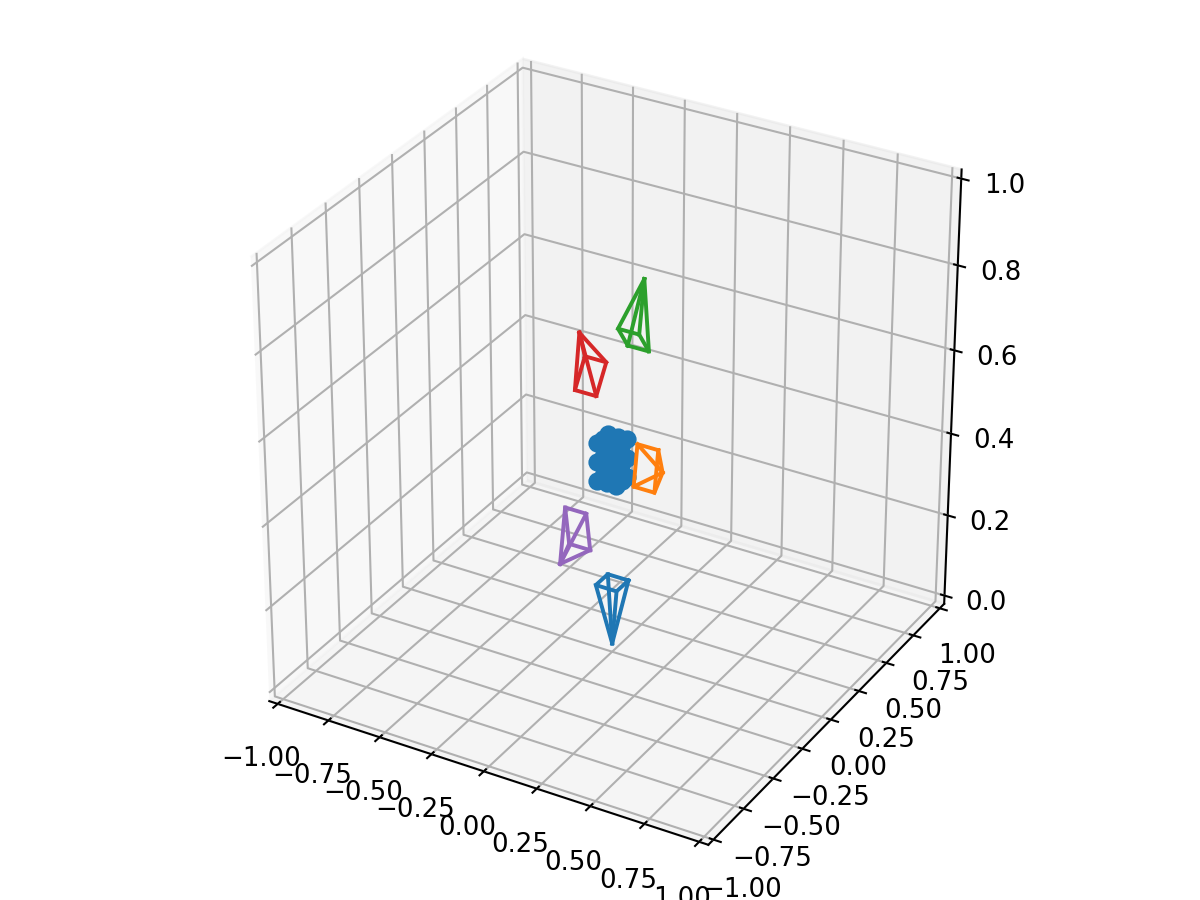

In [6]:
fig = plt.figure()
ax = Axes3D(fig)
ax.set_aspect('equal')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(0, 1)
ax.plot(Y_est[0,:], Y_est[1,:], Y_est[2,:], "o")
cmap = plt.get_cmap("tab10")
for i in range(Nc):
    plotCamera(ax, R_est[i].T, - R_est[i].T @ t_est[i], cmap(i), 0.05)
fig.show()


## Exercise

1. Add Gaussian noise (e.g. $\mu=0, \sigma=1 \mathrm{px}$) to the 2D observations `x`, and see how the results are degraded.
2. Add outliers to `x`.
3. Introduce distortion correction.
   * Assume distorted observations and distortion coefficients are given.  Rectify the observations as a preprocessing.
4. Remove some *connections* between cameras. In the example above, all the cameras are connected each other, i.e., each camera knows the relative pose to all the others. See what happens if the cameras have less connections.   